In [38]:

# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [40]:
train_df = pd.read_csv("/kaggle/input/sign-language-model/sign_mnist_train.csv")
test_df = pd.read_csv("/kaggle/input/sign-language-model/sign_mnist_test.csv")

print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nLabel distribution:\n{train_df['label'].value_counts().sort_index()}")


DATASET INFORMATION
Train shape: (27455, 785)
Test shape: (7172, 785)

Label distribution:
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64


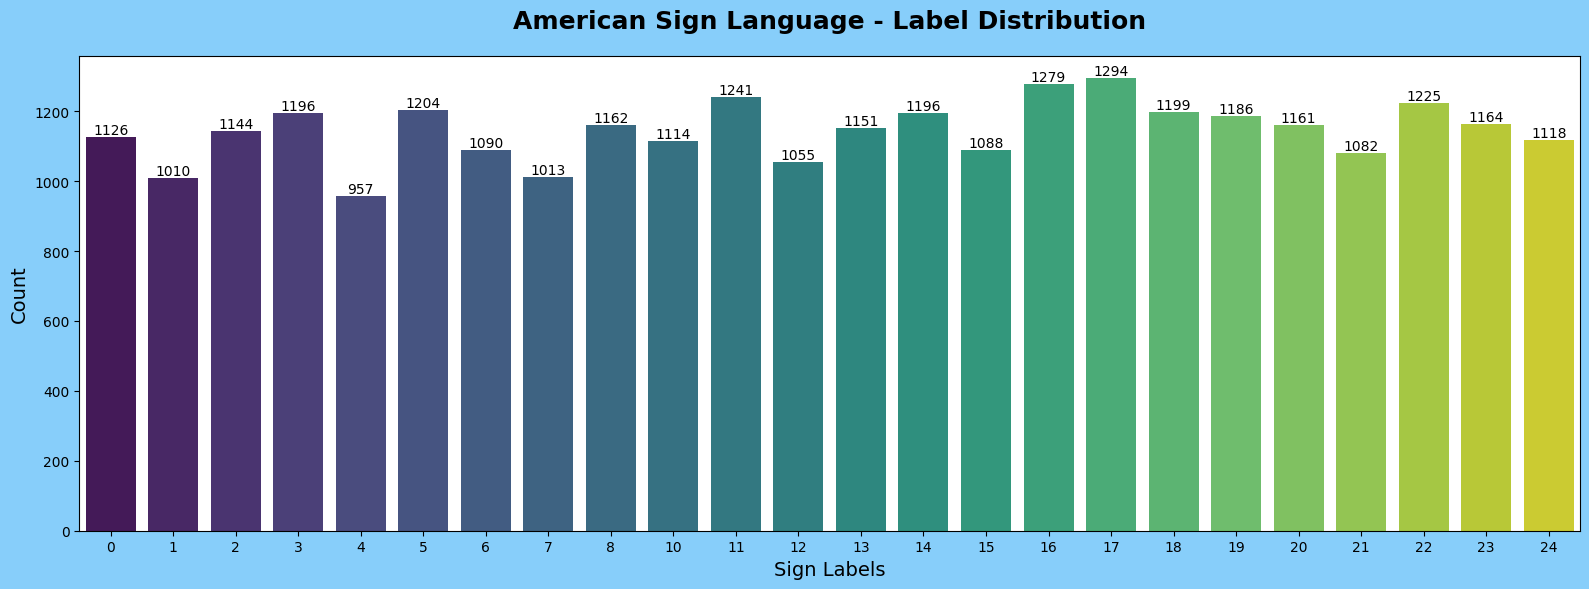

In [41]:
labels = train_df['label'].values
unique_labels = np.unique(labels)

plt.figure(figsize=(16, 6), facecolor='lightskyblue')
ax = sns.countplot(x=labels, palette='viridis')
plt.title('American Sign Language - Label Distribution', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sign Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add count labels on bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

In [42]:
train_labels = train_df['label'].values
train_df.drop('label', axis=1, inplace=True)

images = train_df.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

# Binarize labels
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(train_labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Number of classes: {len(unique_labels)}")

Images shape: (27455, 784)
Labels shape: (27455, 24)
Number of classes: 24


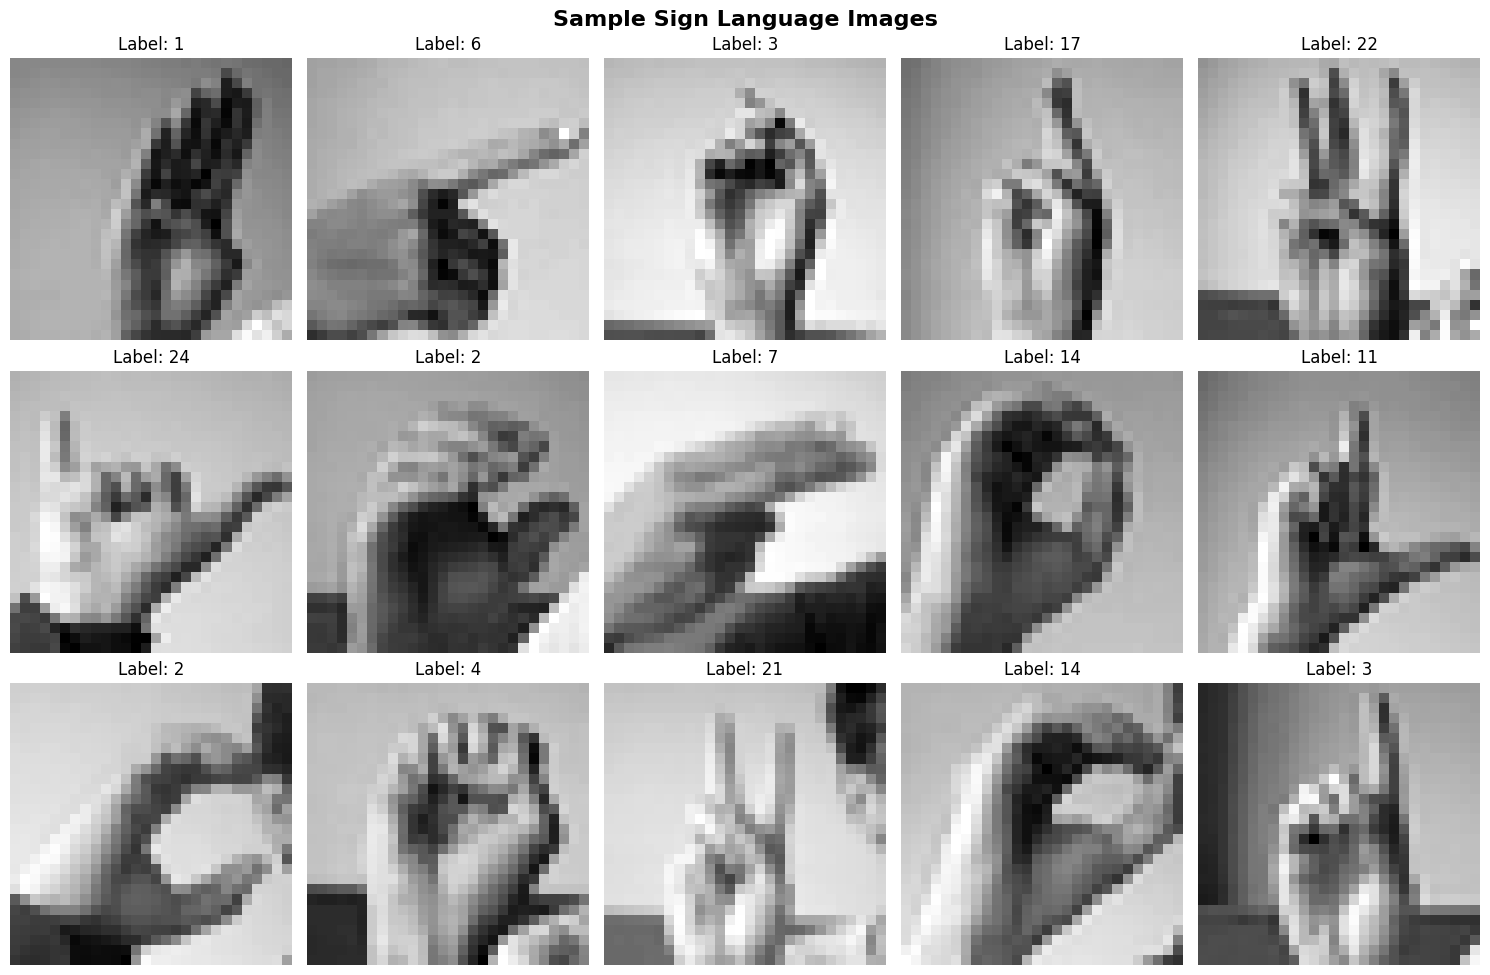

In [43]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Sample Sign Language Images', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < 15:
        rand_idx = np.random.randint(0, len(images))
        ax.imshow(images[rand_idx].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {train_labels[rand_idx]}')
        ax.axis('off')

plt.tight_layout()
plt.show()



In [44]:
x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Normalize
x_train = x_train / 255.0
x_val = x_val / 255.0

# Reshape for CNN
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")

Training set: (21964, 28, 28, 1), (21964, 24)
Validation set: (5491, 28, 28, 1), (5491, 24)


In [45]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1
)
datagen.fit(x_train)


In [46]:
def build_model(input_shape=(28, 28, 1), num_classes=24):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_model(num_classes=len(unique_labels))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           51

 Total params: 472,824 (1.80 MB)

 Trainable params: 471,416 (1.80 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [47]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)


In [48]:
batch_size = 128
epochs = 10

print("=" * 50)
print("TRAINING MODEL")
print("=" * 50)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


TRAINING MODEL
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.1403 - loss: 3.5045 - val_accuracy: 0.0370 - val_loss: 6.2036 - learning_rate: 0.0010
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5374 - loss: 1.4126 - val_accuracy: 0.0410 - val_loss: 5.8779 - learning_rate: 0.0010
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7519 - loss: 0.7460 - val_accuracy: 0.7787 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8501 - loss: 0.4561 - val_accuracy: 0.9292 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9038 - loss: 0.2991 - val_accuracy: 0.9860 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9379 - loss: 0.2004 - val_accuracy: 0.7893 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0

In [49]:
model.save('sign_language_model.h5')
print("\n✓ Model saved successfully!")


✓ Model saved successfully!


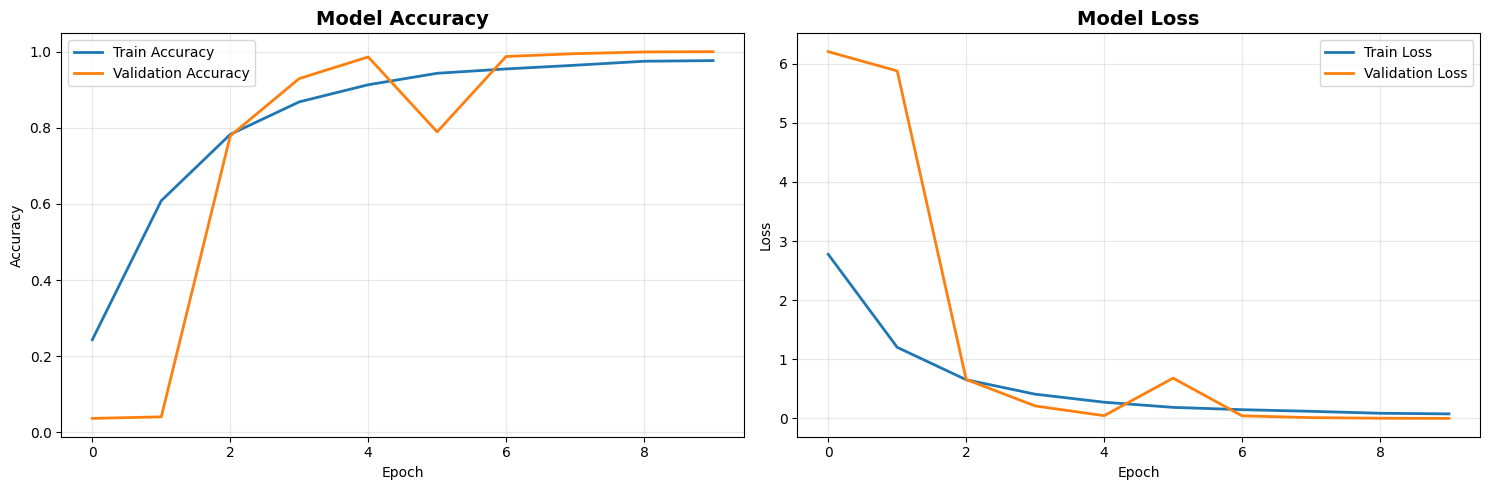

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
test_labels = test_df['label'].values
test_df.drop('label', axis=1, inplace=True)

test_labels_binary = label_binarizer.transform(test_labels)
test_images = test_df.values
test_images = test_images.reshape(-1, 28, 28, 1) / 255.0

# Predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels_binary, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\n{'=' * 50}")
print(f"TEST ACCURACY: {test_accuracy * 100:.2f}%")
print(f"{'=' * 50}\n")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

TEST ACCURACY: 100.00%



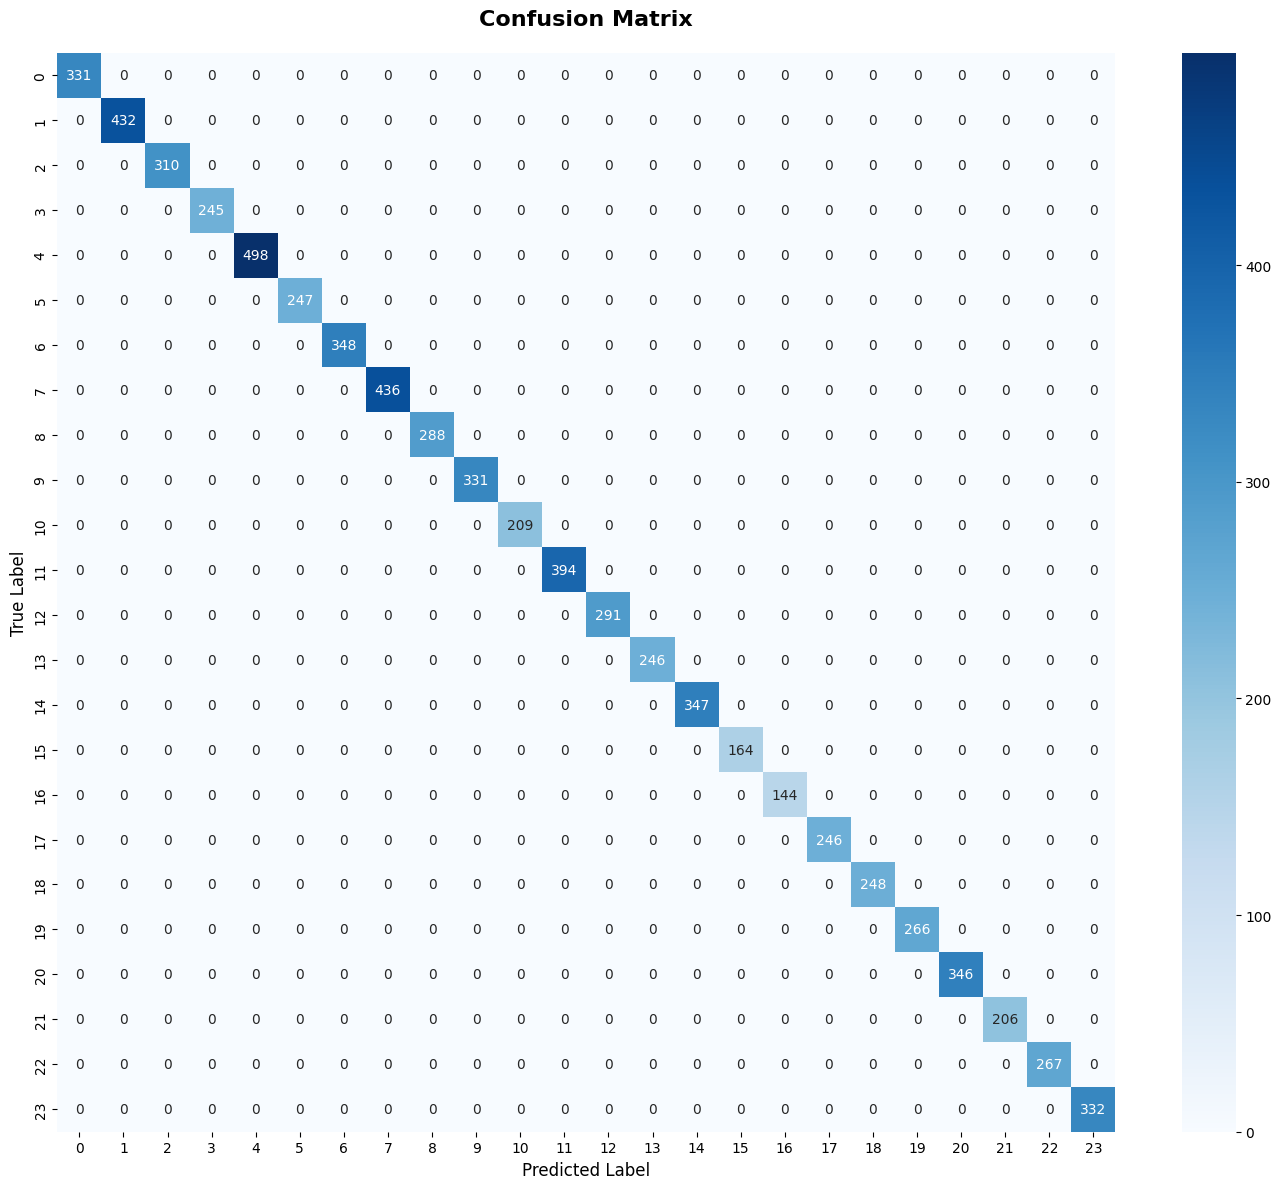

In [52]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [53]:
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true_classes, y_pred_classes))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       1.00      1.00      1.00       144
     

In [56]:
def get_letter(result):
    """Convert numeric prediction to letter"""
    class_labels = {
        0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
        9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R',
        17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'
    }
    try:
        return class_labels[int(result)]
    except:
        return "Error"

def preprocess_custom_image(image_path):
    """Preprocess custom image for prediction"""
    # Read image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Error: Could not read image")
        return None
    
    # Resize to 28x28
    img_resized = cv2.resize(img, (28, 28))
    
    # Normalize
    img_normalized = img_resized / 255.0
    
    # Reshape for model
    img_final = img_normalized.reshape(1, 28, 28, 1)
    
    return img_final, img_resized

def predict_sign(image_path, model, show_image=True):
    """Predict sign language from custom image"""
    # Preprocess
    processed_img, original_resized = preprocess_custom_image(image_path)
    
    if processed_img is None:
        return
    
    # Predict
    prediction = model.predict(processed_img, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    predicted_letter = get_letter(predicted_class)
    
    # Display results
    if show_image:
        plt.figure(figsize=(10, 4))
        
        # Original resized image
        plt.subplot(1, 2, 1)
        plt.imshow(original_resized, cmap='gray')
        plt.title('Input Image (28x28)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Prediction probabilities
        plt.subplot(1, 2, 2)
        top_5_idx = np.argsort(prediction[0])[-5:][::-1]
        top_5_prob = prediction[0][top_5_idx] * 100
        top_5_letters = [get_letter(i) for i in top_5_idx]
        
        colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
        plt.barh(top_5_letters, top_5_prob, color=colors)
        plt.xlabel('Confidence (%)', fontsize=12)
        plt.title('Top 5 Predictions', fontsize=12, fontweight='bold')
        plt.xlim(0, 100)
        
        for i, (letter, prob) in enumerate(zip(top_5_letters, top_5_prob)):
            plt.text(prob + 1, i, f'{prob:.1f}%', va='center')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n{'=' * 50}")
    print(f"PREDICTION RESULT")
    print(f"{'=' * 50}")
    print(f"Predicted Letter: {predicted_letter}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"{'=' * 50}\n")
    
    return predicted_letter, confidence



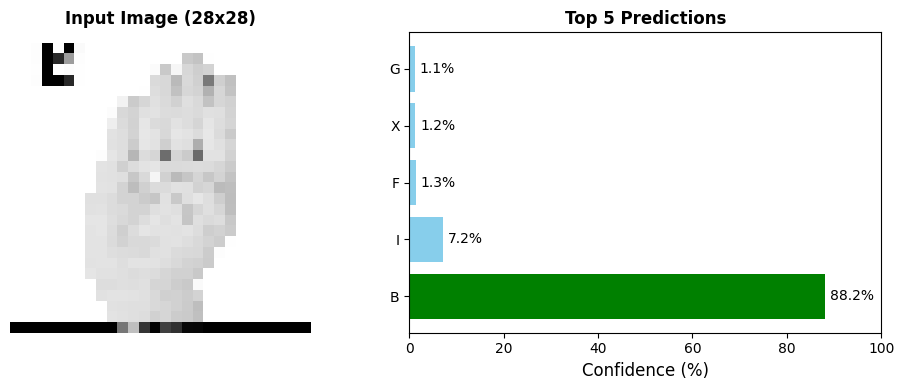


PREDICTION RESULT
Predicted Letter: B
Confidence: 88.20%



('B', 88.20058703422546)

In [59]:
image_path = '/kaggle/input/bmodek/B.jpg'
predict_sign(image_path, model)